# Task 3

In [15]:
import pygad 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def read_graph(path):
    with open(path) as f: n = int(f.readline())
    print(n)
    graph = pd.read_csv(path, sep=" ", skiprows=1, names=["A", "B", "w"])
    print(graph)
    return n, graph

In [30]:
# choose graph
path = "../graphs/g3.txt"

n, graph = read_graph(path)
k = 1    # genome length scaling factor
numAgents = 3
agent_len = n * k

# select a sequence to be visited
sequence = [1,10]

12
     A   B  w
0    1   4  7
1    1   7  9
2    1   9  4
3    1  11  4
4    2   1  3
..  ..  .. ..
66  12   1  2
67  12   6  3
68  12   9  3
69  12  10  4
70  12  11  7

[71 rows x 3 columns]


In [31]:
# simulate moving of agents
# the result is the total time for all to finish
INVALID = -1e12

def fitness_fun3(pygad_instance, genom, solution_index):
#def path(genom, numAgents, agent_len):
    paths = np.array(genom).reshape(numAgents, agent_len)  # in each row is one agent
    position = np.zeros(numAgents, dtype=int)
    unfinished = set(range(numAgents))

    time = np.ones(numAgents, dtype=int)
    moving = np.zeros(numAgents).astype(bool)  # True = agent is moving, False = agent waiting
    sequenceIx = np.zeros(numAgents, dtype=int)
    end = len(sequence)

    occupiedNodes = set()
    occupiedEdges = set()

    totalTime = 0

    # occupy start nodes
    for agent in range(numAgents):
        startNode = paths[agent][0]
        # prehitro pridemo do invalid?
        if(startNode in occupiedNodes): return INVALID
        #if(startNode in occupiedNodes): time[agent] += 20
        occupiedNodes.add(startNode)

    while(unfinished):
        time -= 1
        for agent in range(numAgents):
            if(time[agent] == 0):
                # agents turn

                if(moving[agent]):
                    # has just moved to new node
                    ix = position[agent]
                    prevNode = paths[agent][ix - 1]
                    nextNode = paths[agent][ix]

                    # check if new node is free

                    # Tudi tukaj ni ok, če je nextNode occupied mora počakat???
                    #if(nextNode in occupiedNodes): return INVALID

                    if(nextNode in occupiedNodes):
                        time[agent] += 20
                        continue

                    # ocuppy node + wait for 10
                    occupiedEdges.discard((prevNode, nextNode))
                    occupiedNodes.add(nextNode)
                    time[agent] += 10
                    moving[agent] = False

                else:
                    # agent has to move
                    ix = position[agent]
                    currNode = paths[agent][ix]

                    # check if current node is the end == FINISH :)
                    if(sequenceIx[agent] == end): 
                        unfinished.remove(agent)
                        occupiedNodes.discard(currNode)
                        continue

                    # check if the agent finished his path
                    if(ix + 1 == agent_len): return INVALID

                    # plan move
                    nextNode = paths[agent][ix + 1]
                    if(nextNode == currNode):
                        # if next node is the same - wait (dont set moving=True)
                        time[agent] += 20
                        position[agent] += 1
                        continue
                    else:
                        # check if connection is valid & free

                        # to že avtomatsko returna invalid, bi moglo samo podaljšati čas čakanja (navodila), isto kot za zaseden node
                        #if((currNode, nextNode) in occupiedEdges): return INVALID

                        if((currNode, nextNode) in occupiedEdges):
                            time[agent] += 20
                            continue
                        else: 

                            w = graph.loc[(graph['A'] == currNode) & (graph['B'] == nextNode), 'w']
                            if w.empty:
                                return INVALID

                            # check if node is in sequence -> MARK
                            it = sequenceIx[agent]
                            if(it < end and nextNode == sequence[it]): 
                                sequenceIx[agent] += 1

                            # move & free node (set moving=True)
                            occupiedNodes.discard(currNode)
                            occupiedEdges.add((currNode, nextNode))
                            time[agent] += w.iloc[0]
                            moving[agent] = True

                            position[agent] += 1        

        totalTime += 1

    return totalTime


In [32]:
## vsak agent ima drugačen starting node
def creating_init_pop_task3(n, agent_len, numAgents):
    pop = []


    full_gene_space = [node for node in range(1, n+1)]
    number_of_nodes_to_insert = agent_len - len(sequence)

    possible_indices = list(range(agent_len))


    for _ in range(50):   # v oklepaju solutions per population
        genoms = np.zeros(agent_len * numAgents, dtype=int)
        ix = 0
        zacetni_nodi = set()

        # we repeat the same process but for each agent
        for _ in range(numAgents):
            indices = possible_indices.copy()
            positions = []
            
            # index 0 is automatically in the nodes that we are going to insert

            positions.append(0)
            indices.remove(0)
            for _ in range(1, number_of_nodes_to_insert):
                idx = np.random.choice(indices)
                indices.remove(idx)
                positions.append(idx)


            # building process :)
            agent = [-1] * agent_len   # list of n elements with value -1

            for x in positions:
                if x == 0:
                    zacetno = np.random.choice(full_gene_space)
                    while zacetno in zacetni_nodi:
                        zacetno = np.random.choice(full_gene_space)
                    else: 
                        agent[x] = zacetno
                        zacetni_nodi.add(zacetno)

                else:
                    agent[x] = np.random.choice(full_gene_space)

            
            it = 0
            for i in range(agent_len):
                if agent[i] == -1:
                    genoms[ix] = sequence[it]
                    it += 1
                else:
                    genoms[ix] = agent[i]
                ix += 1
            
        pop.append(genoms)
    
    return pop

In [33]:
def crossover_task3(parents, offspring_size, ga_instance):
    offspring = []
    
    size_of_offspring, number_of_genes = offspring_size

    parents_size = len(parents)

    def check_sequence(p1, p2, idx, agent_id):
        id = 0
        for i in range(idx):
            if p1[agent_id*agent_len+i]==sequence[id]:
                id += 1
            if id == len(sequence):
                return True
        for i in range(idx, agent_len):
            if p2[agent_id*agent_len+i]==sequence[id]:
                id += 1
            if id == len(sequence):
                return True

        return False
    

    for i in range(size_of_offspring):
        # randomly choose 2 parents
        parent_indices = np.random.choice(parents_size, 2, replace=False)
        parent1 = parents[parent_indices[0]]
        parent2 = parents[parent_indices[1]]


        individual_offspring = np.array([], dtype=int)



        # now we traverse, and decide on available points for crossover, while maintaining sequence
        for agent_id in range(numAgents):
            available_points_for_crossover = []

            for potential in range(agent_len):
                if check_sequence(parent1, parent2, potential, agent_id):
                    available_points_for_crossover.append(potential)

        
            if available_points_for_crossover :
                chosen_crossover_point = np.random.choice(available_points_for_crossover)

                # combine parents to get child for one agent
                individual_offspring_agent = np.concatenate([parent1[agent_id * agent_len : agent_id * agent_len + chosen_crossover_point], 
                                                            parent2[agent_id * agent_len + chosen_crossover_point : (agent_id+1)*agent_len]])
            else:
                individual_offspring_agent = parent1[agent_id * agent_len:(agent_id+1) * agent_len]

            individual_offspring = np.concatenate([individual_offspring, individual_offspring_agent])

        offspring.append(individual_offspring)


    return np.array(offspring)


def mutation_task3(offspring, ga_instance):
    mutation_probability = 0.1 

    # we are gpoing to mutate one gene per agent
    
    # idea: swap two genes - not if they are both in sequence

    # new thingy: change xth gen with a node from gene_spece, only if the new node has connection to x+1
    # and x-1 has connection to x-1

    for offspring_individual in offspring:
        if np.random.random() < mutation_probability:  # so it doesnt mutate all of the offspring individuals


            length = len(offspring_individual)

            gene_space = [i for i in range(1, n+1)]


            for agent_id in range(numAgents):

                swap_points = []

                for i in range(0, agent_len):
                    currNode = offspring_individual[agent_id*agent_len + i]
                    if currNode in sequence:
                        continue
                    if i == 0: # starting node
                        nextNode = offspring_individual[agent_id*agent_len + i + 1]
                        ix = int(np.random.choice(gene_space))
                        w = graph.loc[(graph['A'] == ix) & (graph['B'] == nextNode), 'w']
                        # imajo 20 poskusov, da se ne ulovimo v neskoncno zanko
                        timeout = 0
                        while w.empty and timeout < 20:
                            x = int(np.random.choice(gene_space))
                            w = graph.loc[(graph['A'] == ix) & (graph['B'] == nextNode), 'w']
                            timeout += 1
                        if timeout < 20:
                            swap_points.append((i, ix))
                    elif i == agent_len-1:
                        prevNode = offspring_individual[agent_id*agent_len + i - 1]
                        ix = int(np.random.choice(gene_space))
                        w = graph.loc[(graph['A'] == prevNode) & (graph['B'] == ix), 'w']
                        timeout = 0
                        while w.empty and timeout < 20:
                            ix = int(np.random.choice(gene_space))
                            w = graph.loc[(graph['A'] == prevNode) & (graph['B'] == ix), 'w']
                            timeout += 1
                        if timeout < 20:
                            swap_points.append((i, ix))
                    else:
                        prevNode = offspring_individual[agent_id*agent_len + i - 1]
                        nextNode = offspring_individual[agent_id*agent_len + i + 1]
                        ix = int(np.random.choice(gene_space))
                        w1 = graph.loc[(graph['A'] == prevNode) & (graph['B'] == ix), 'w']
                        w2 = graph.loc[(graph['A'] == ix) & (graph['B'] == nextNode), 'w']
                        timeout = 0
                        while (w1.empty or w2.empty) and timeout < 20:
                            ix = int(np.random.choice(gene_space))
                            w1 = graph.loc[(graph['A'] == prevNode) & (graph['B'] == ix), 'w']
                            w2 = graph.loc[(graph['A'] == ix) & (graph['B'] == nextNode), 'w']
                            timeout += 1
                        if timeout < 20:
                            swap_points.append((i, ix))

                if swap_points:
                    index, new_node = swap_points[np.random.randint(len(swap_points))]
                    offspring_individual[agent_id*agent_len+index] = new_node

    return offspring

In [46]:
def genetic_algo_task3(number_generations, number_parents_mating):
    init_pop = creating_init_pop_task3(n, agent_len, numAgents)
    #print(init_pop)
    gene_space = [i for i in range(1, n+1)]


    ga_instance = pygad.GA(fitness_func=fitness_fun3,
                       num_generations=number_generations,
                       num_parents_mating=number_parents_mating,
                       initial_population=init_pop,
                       sol_per_pop=50,
                       num_genes=(agent_len * numAgents),
                       gene_space=gene_space,
                       gene_type=int,
                       crossover_type=crossover_task3,
                       mutation_type=mutation_task3,
                       mutation_probability=0.1
                      )

    ga_instance.run()

    #solution, solution_fitness, solution_idx = ga_instance.best_solution()
    #print(-solution_fitness)

    print("best solution: ", ga_instance.best_solution())
    ga_instance.plot_fitness()

    return abs(ga_instance.best_solution()[1])

best solution:  (array([ 5,  2,  1, 11, 10, 12, 10,  1,  4, 11, 10, 10, 10,  1, 11, 10, 12,
       10, 12,  1, 11, 10,  7,  6, 11,  1,  1, 11,  1,  4,  8, 10, 12, 11,
        1, 10]), np.float64(157.0), np.int64(0))


c:\Users\tases\miniconda3\envs\intelsys\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


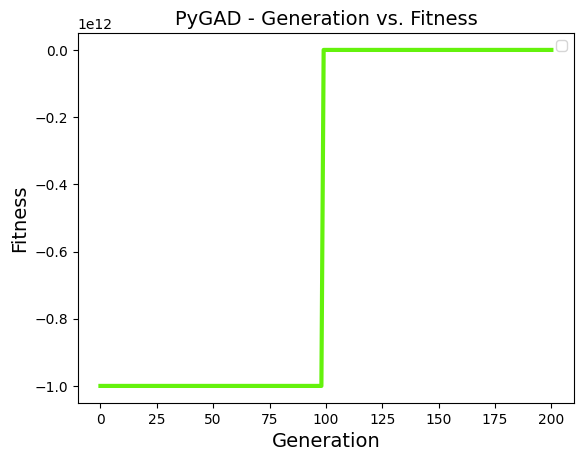

np.float64(157.0)

In [35]:
genetic_algo_task3(200, 5)

best solution:  (array([7, 1, 1, 7, 4, 7, 4, 7, 3, 7, 4, 7, 4, 8, 1, 4, 3, 2, 1, 4, 7, 3,
       5, 2]), np.float64(215.0), np.int64(0))


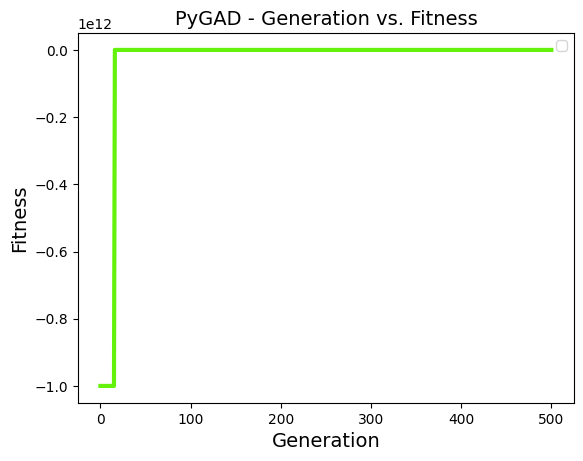

best solution:  (array([1, 4, 7, 1, 1, 7, 4, 7, 1, 7, 3, 7, 1, 7, 1, 4, 7, 1, 7, 4, 1, 7,
       3, 7, 7, 1, 4, 1, 7, 4, 7, 1, 4, 3, 7, 3]), np.float64(-1000000000000.0), np.int64(0))


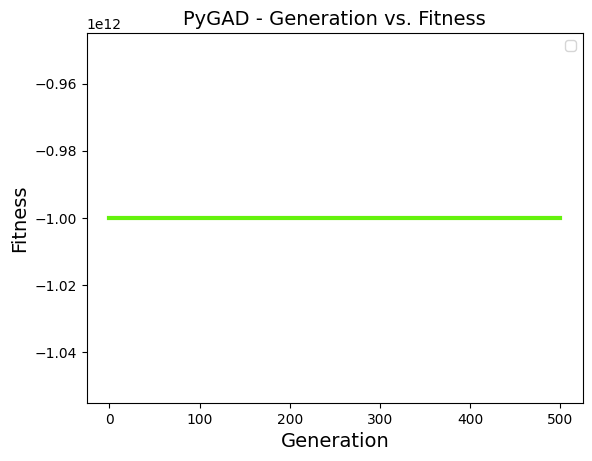

best solution:  (array([ 7,  4,  7,  1,  4,  4,  1,  7,  1,  4,  7,  3,  7,  1,  1,  7,  3,
        7,  4,  7,  3,  8,  7,  3, 10,  7,  8,  3,  7,  3,  1,  4,  7,  3,
        7,  3,  7,  1,  1,  1,  4,  4,  7,  3,  3,  7,  4,  3,  1,  7,  1,
        4,  7,  1,  4,  1,  7,  3,  7,  4]), np.float64(-1000000000000.0), np.int64(0))


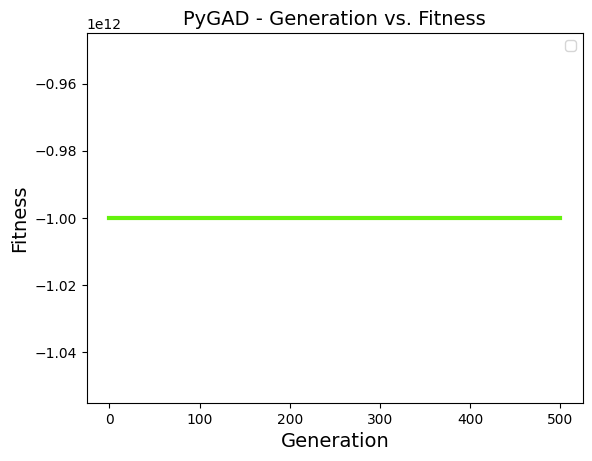

best solution:  (array([1, 4, 7, 1, 4, 7, 3, 7, 7, 3, 7, 1, 7, 1, 7, 1, 4, 7, 4, 3, 7, 7,
       7, 3, 3, 7, 4, 3, 1, 4, 7, 3, 1, 4, 7, 3, 7, 4, 7, 3, 7, 1, 4, 7,
       4, 3, 7, 3, 4, 3, 7, 3, 7, 4, 1, 4, 7, 3, 4, 3, 1, 1, 7, 4, 3, 7,
       4, 1, 4, 3, 7, 1, 3, 7, 1, 4, 7, 3, 7, 1, 4, 3, 7, 4]), np.float64(-1000000000000.0), np.int64(0))


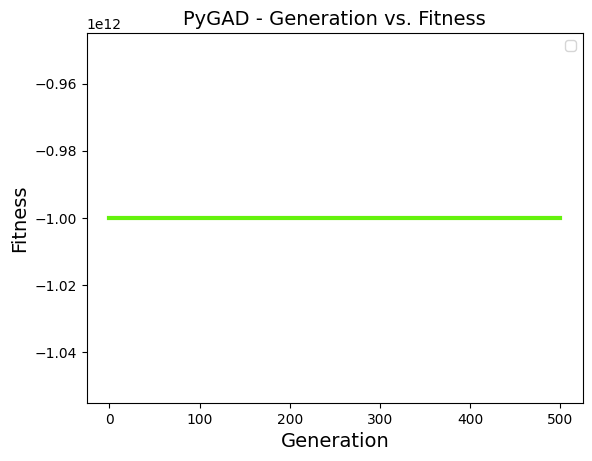

In [36]:
# shrani rezultat v .csv dolocen v path
# stolpci so stevilo generacij
# vsaka vrstica je rezultat za en graf (ce hoces kaksno odstranit jo samo zbrises)
# -> to potem narise v report -would be nice ce bi algoritem delal :)

# run with different generation sizes
number_agents = [2, 3, 5, 7]
csv_path = "NumAgentsResults.csv"
results = {}

numAgents = 0
sequence = [1, 4, 7, 3]

for m in number_agents:
    numAgents = m
    fitness = genetic_algo_task3(
        number_generations=500,
        number_parents_mating=5,
    )

    results[f"num_agents_{m}"] = fitness  #a map

# change to pandas dataframe
df_row = pd.DataFrame([results])

# Save or append
if not os.path.exists(csv_path):
    df_row.to_csv(csv_path, index=False)
else:
    df_row.to_csv(csv_path, mode="a", header=False, index=False)

best solution:  (array([ 2,  1,  7,  4, 11,  1,  4,  1,  4,  1,  7,  4,  1,  4,  1,  4,  1,
        7,  4,  1,  4, 10,  1,  4,  4,  8,  1,  4, 11, 10, 11,  1,  4,  5,
       12,  1]), np.float64(90.0), np.int64(0))


c:\Users\tases\miniconda3\envs\intelsys\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


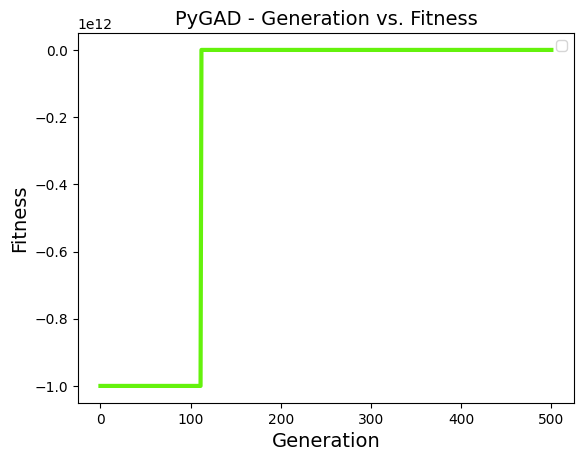

best solution:  (array([ 4,  1,  7, 11,  1,  7,  4, 11, 11,  1,  7,  4, 11,  1,  4,  7,  1,
        4, 10,  1,  4,  7,  4,  7, 12, 10, 12,  1,  4,  7,  1,  1,  4,  7,
       10, 12]), np.float64(204.0), np.int64(0))


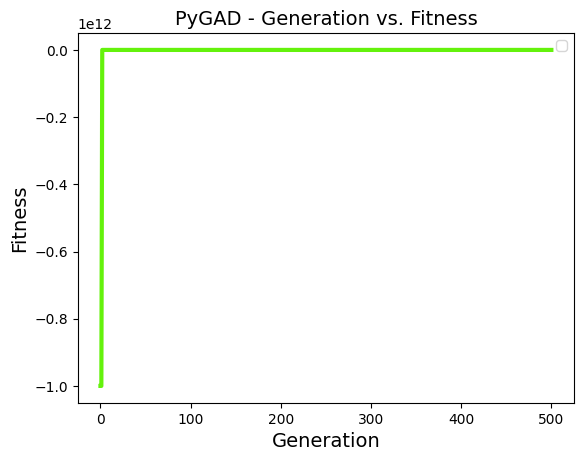

best solution:  (array([9, 5, 4, 1, 4, 1, 7, 3, 7, 3, 9, 3, 4, 1, 4, 1, 4, 4, 7, 3, 3, 3,
       9, 1, 7, 1, 3, 4, 1, 9, 7, 4, 3, 3, 9, 2]), np.float64(-1000000000000.0), np.int64(0))


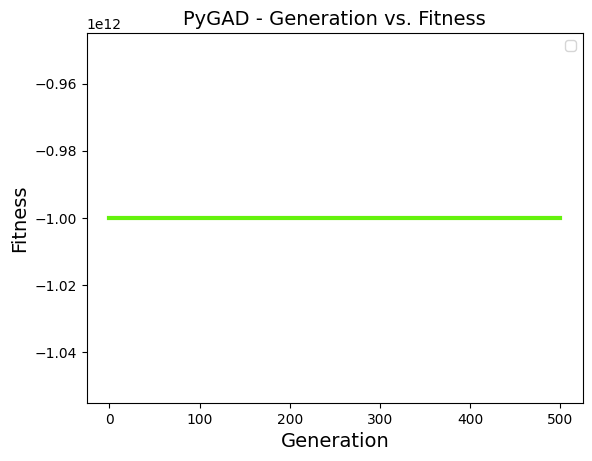

best solution:  (array([ 3,  1,  4,  7,  3,  3,  9,  5,  8, 10, 12,  3, 10,  1,  4,  7,  3,
        9,  5,  8,  8, 10, 12,  3, 12,  1,  4,  4,  7,  3,  9,  5,  8, 10,
       12,  3]), np.float64(-1000000000000.0), np.int64(0))


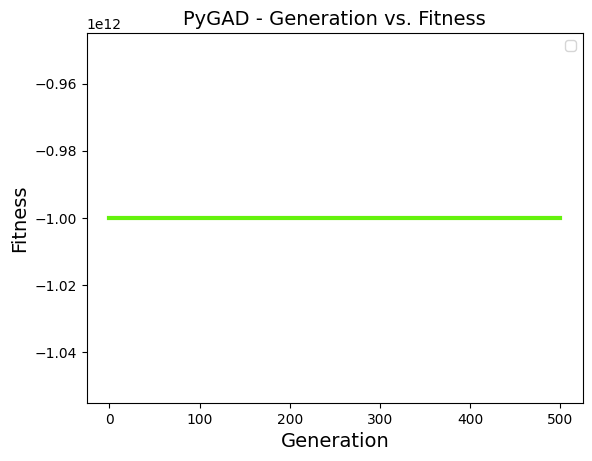

In [38]:
# shrani rezultat v .csv dolocen v path
# stolpci so stevilo generacij
# vsaka vrstica je rezultat za en graf (ce hoces kaksno odstranit jo samo zbrises)
# -> to potem narise v report -would be nice ce bi algoritem delal :)

# run with different generation sizes
seq_len = [2, 3, 5, 10]
seq = [1, 4, 7, 3, 9, 5, 8, 10, 12, 3]
csv_path = "LenSeqResults.csv"
results = {}

numAgents = 3
sequence = []

for s in seq_len:
    sequence = seq[:s]
    fitness = genetic_algo_task3(
        number_generations=500,
        number_parents_mating=5,
    )

    results[f"len_seq_{s}"] = fitness  #a map

# change to pandas dataframe
df_row = pd.DataFrame([results])

# Save or append
if not os.path.exists(csv_path):
    df_row.to_csv(csv_path, index=False)
else:
    df_row.to_csv(csv_path, mode="a", header=False, index=False)

best solution:  (array([ 4,  1,  1,  4,  1,  7,  7,  4,  1,  7,  3,  7,  3,  5,  4,  1,  4,
        7,  3,  7,  3,  3,  7,  3, 11,  1,  4, 11,  3,  7,  4,  7,  4,  3,
        3,  7]), np.float64(298.0), np.int64(0))


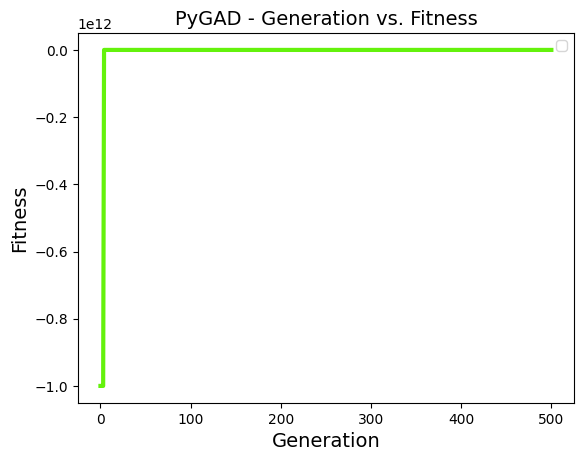

best solution:  (array([12,  1,  4,  1,  7, 10,  7,  4,  7,  3,  8,  7,  7,  1,  4,  1,  7,
        3,  7,  4,  7,  3,  3,  7,  4,  1,  4, 10,  7,  1,  7,  1,  7, 11,
        6,  3]), np.float64(329.0), np.int64(0))


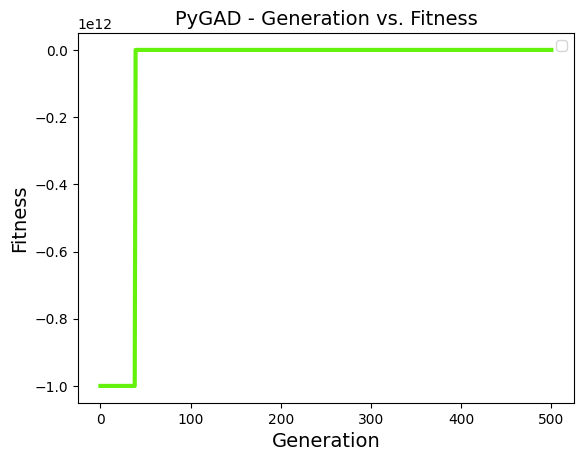

best solution:  (array([ 1,  7,  1,  4,  4,  4,  3,  7,  4,  3,  1,  7,  3, 12,  1,  4,  1,
        4,  4,  7,  7,  1,  7,  3,  7,  8,  1,  1,  4,  1,  4,  7,  4,  3,
        7,  3]), np.float64(373.0), np.int64(0))


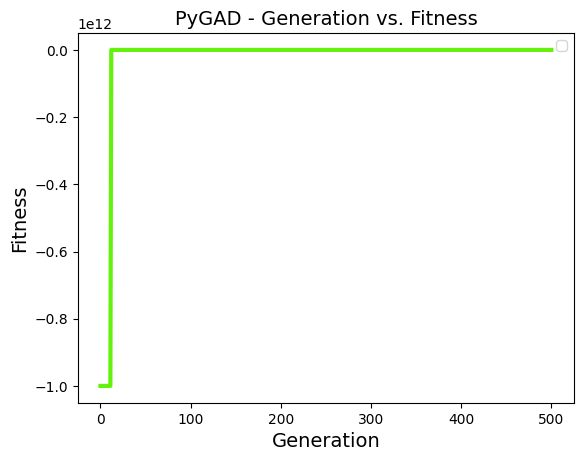

best solution:  (array([1, 7, 1, 7, 4, 7, 1, 3, 7, 3, 7, 3, 3, 1, 7, 1, 4, 7, 1, 7, 4, 7,
       4, 3, 4, 1, 4, 3, 7, 4, 3, 7, 4, 7, 3, 4]), np.float64(-1000000000000.0), np.int64(0))


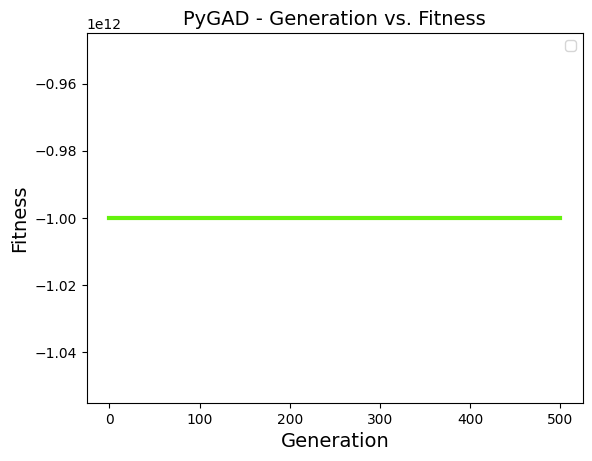

In [45]:
mut_prob = [0.1, 0.2, 0.4, 0.6]
sequence = [1, 4, 7, 3]
csv_path = "MutProbResults.csv"
results = {}

numAgents = 3

for m in mut_prob:
    fitness = genetic_algo_task3(
        number_generations=500,
        number_parents_mating=5,
        mutation_probability=m
    )

    results[f"mut_prob_{m}"] = fitness  #a map

# change to pandas dataframe
df_row = pd.DataFrame([results])

# Save or append
if not os.path.exists(csv_path):
    df_row.to_csv(csv_path, index=False)
else:
    df_row.to_csv(csv_path, mode="a", header=False, index=False)